### Connect Four Project

The aim of this project is to develop a Connect Four game that implements Artificial Intelligence algorithms that will be used to play against the user and against each other.

We'll implement search and adversarial algorithms, namely:

* ``A* Search algorithm`` 
* ``Monte Carlo Search Tree algorithm``
* ``Mini Max algoritm with alpha-beta prunning``



### Board

We'll start by implementing the Board class that will be used to represent the board of the connect four game.

The following code represents the Board class alongside some helper methods:

In [1]:
#Player tokens as global variables
PLAYER1 = 'X'
PLAYER2 = 'O'

class Board:

    #Board Initializer
    def __init__(self, rows, cols, turn):
        self.rows = rows
        self.cols = cols
        self.score = 0
        self.game_over = False
        self.grid = [['-' for _ in range(cols)] for _ in range(rows)]
        self.turn = turn
        self.last_move = None
        self.algorithm = None
        
    
    
    #Check if column is valid
    def valid_col(self, col):
        if col < 0 or col >= self.cols:
            return False  # Column out of range
        return '-' in [row[col] for row in self.grid]  # Check if the column has empty slots

    
    def __lt__(self, board):
            return self.score < board.score 
    
    #Changes player turn
    def change_turn(self):
        if self.turn == 'X':
            self.turn = 'O'
        else:
            self.turn = 'X'

    #Prints board       
    def print_board(self):
        for row in self.grid:
            print(" ".join(row))

    #Drop Piece function used for the A* and MiniMax Algorithm
    def drop_piece_search(self, col):
        for row in range(self.rows - 1, -1, -1):
            if self.grid[row][col] == '-':
                self.grid[row][col] = self.turn
                self.change_turn() 
                self.evaluate()
                
                self.last_move = col
                return True
        return False
    
    #Drop piece method used for the MCTS algorithm
    def drop_piece_adversarial(self, col):
        for row in range(self.rows -1 , -1 , -1):
            if self.grid[row][col] == '-':
                self.grid[row][col] = self.turn
                self.last_move = col
                self.check_winner(self.turn)
                #print(self.print_board())
                return True
                
        return False
        
    #Makes a copy of the board
    def copy(self):
        new_grid = [[item for item in row] for row in self.grid]  
        new_board = Board(self.rows, self.cols, self.turn)
        new_board.grid = new_grid
        return new_board
    
    def __str__(self):

        board_string = ""
        for row in self.grid:
            board_string += "".join(row) + "\n"  
        return board_string.rstrip() 
    
    
    #Get array of legal moves
    def get_legal_moves(self):
        legal_moves = []
        for col in range(self.cols):
            if self.grid[0][col] == '-' :
                legal_moves.append(col)
        return legal_moves

    #Check if the board is full
    def is_full(self):
        return all(self.grid[0][col] != '-' for col in range(self.cols))

    #Get a segment of size 4
    def get_segment(self, start_row, start_col, d_row, d_col):
        segment = []
        for i in range(4):
            row = start_row + i * d_row
            col = start_col + i * d_col
            segment.append(self.grid[row][col])
        return segment
    
    #Check if token "player" won
    def check_winner(self, player):
      
      #Check rows
      for row in range(len(self.grid)):
          for col in range(len(self.grid[0]) - 3):
              if all(self.grid[row][col + i] == player for i in range(4)):
                  self.game_over= player
                  return True
      #Check cols
      for row in range(len(self.grid) - 3):
          for col in range(len(self.grid[0])):
              if all(self.grid[row + i][col] == player for i in range(4)):
                self.game_over= player
                return True

      #Check diagonals
      for row in range(len(self.grid) - 3):
          for col in range(len(self.grid[0]) - 3):
              if all(self.grid[row + i][col + i] == player for i in range(4)):
                self.game_over= player
                return True
              if all(self.grid[row + 3 - i][col + i] == player for i in range(4)):
                  self.game_over= player
                  return True

      return False
    
    #Generates succesors for the A* and MiniMax algorithm
    def get_successors(self):
        successors = []
        possible_moves = []

        for i in range(self.cols):
            suc = self.copy()
            if suc.drop_piece_search(i):
                successors.append(suc)
                possible_moves.append(i)
        return successors, possible_moves
    
    #Generates successors for the MCTS algorithm
    def successors(self):
        successors=[]
        possible_moves = []
        for col in range(self.cols):
            suc = self.copy()
            if suc.drop_piece_adversarial(col):
                successors.append(suc)
                possible_moves.append(col)
                suc.change_turn()

        return successors, possible_moves
            
    
    def get_opponent(self):
        if self.turn == 'X':
            return 'O'
        else:
            return 'X'
        
    def segment_has_both(self,segment):
        player2_count = 0
        player1_count = 0
        for i in segment:
            if i == PLAYER2:
                player2_count += 1
            if i == PLAYER1:
                player1_count += 1

        return player2_count != 0 and player1_count != 0


    def evaluate_segment(self, segment):
        if self.segment_has_both(segment) or segment.count(self.turn) == 0:
            return 0
        
        if  segment.count(self.turn) == 3 :
            if(self.turn== PLAYER1):
                return 50
            else:
                return -50
        if  segment.count(self.turn) == 2 :
            if(self.turn == PLAYER1):
                return 10
            else:
                return -10
        if  segment.count(self.turn) == 1 :
            if(self.turn == PLAYER1):
                return 1
            else:
                return -1
        return 0
     #Heuristic function for the A* and MiniMax algorithms
    def evaluate(self):
        total_score = 0
        if self.check_winner(PLAYER1):
            total_score +=  512 
        if self.check_winner(PLAYER2):
            total_score += -512

        for row in range(self.rows):
            for col in range(self.cols - 3):
                segment = self.get_segment(row, col, 0, 1)                
                total_score += self.evaluate_segment(segment)

        for col in range(self.cols):
            for row in range(self.rows - 3):
                segment = self.get_segment(row, col, 1, 0)                
                total_score += self.evaluate_segment(segment)

        for row in range(self.rows - 3):
            for col in range(self.cols - 3):
                segment = self.get_segment(row, col, 1, 1)
                total_score += self.evaluate_segment(segment)

        for row in range(self.rows - 3):
            for col in range(self.cols - 3):
                segment = self.get_segment(row + 3, col, -1, 1)                
                total_score += self.evaluate_segment(segment)

        if self.turn == PLAYER1:
            total_score += 16
        else:
            total_score -= 16
        self.score = total_score    
        return self.score
        
    
    
    

#### A* Search Algorithm

#### Overview:

* A* is an informed search/best-first search algorithm

    *  Formulated in terms of weighted graphs, starting from a specific node

    *  Its goal is to find a path to the given goal node with the smallest cost





#### Evaluation function:

To determine which node should be expanded at each iteration in the main loop we need a function to to minimize the cost of the path:

* ```f(n) = g(n) + h(n)```, where n represents the next node

The 2 components of the f(n) function are:

* ```g(n)```, that represents the cumulative cost of the path from the start node up until the current node. In this case since we'll be working with an unweighted graph, the cost of the g(n) component will always be equal to 0

* ```h(n)```, the heurist function that estimates the cost of the cheapest path from n to the goal node

We'll be focusing on implementing the heuristic function (h(n)), that will be tailored to our Connect Four problem that has a specific evaluator. 

This heuristic was implemented in the Board class since it will be shared among the MiniMax and A* algorithms and is called by the ```drop_piece```method for 

```python

def evaluate(self):
        total_score = 0
        if self.check_winner(PLAYER1):
            total_score +=  512 
        if self.check_winner(self.PLAYER2):
            total_score += -512

        for row in range(self.rows):
            for col in range(self.cols - 3):
                segment = self.get_segment(row, col, 0, 1)                
                total_score += self.evaluate_segment(segment)

        for col in range(self.cols):
            for row in range(self.rows - 3):
                segment = self.get_segment(row, col, 1, 0)                
                total_score += self.evaluate_segment(segment)

        for row in range(self.rows - 3):
            for col in range(self.cols - 3):
                segment = self.get_segment(row, col, 1, 1)
                total_score += self.evaluate_segment(segment)

        for row in range(self.rows - 3):
            for col in range(self.cols - 3):
                segment = self.get_segment(row + 3, col, -1, 1)                
                total_score += self.evaluate_segment(segment)

        if self.turn == PLAYER1:
            total_score += 16
        else:
            total_score -= 16
        self.score = total_score    
        return self.score



#### Implementation

* Data Structure:
    * A* is typically implemented using a ```priority```  to perform repeated selection of minimum cost nodes to expand

#### Node Class used for A* Algorithm

In [2]:
class Node:
    def init(self, board, player, parent=None, column_played=None):
        self.board = board
        self.player = player
        self.parent = parent
        self.column_played = column_played
        self.score = 0

    def lt(self, node):
        return self.score < node.score 

#### A* Algorithm

In [3]:
from heapq import heappop, heappush
def astar(board, player):
    successors, _ = board.get_successors()

    frontier = []
    for suc in successors:
      if player == 'X':
         suc.score *=-1 #multiplying by -1 
      heappush(frontier, suc)

    best = heappop(frontier)
    return best.last_move

#### Monte Carlo Tree Search Algorithm

In [29]:
import random
import math
import time
import copy

class MCTSNode:
    def __init__(self, board, last = None,parent=None):
        self.state: Board = board
        self.parent = parent
        self.children = []
        self.visits = 0
        self.wins = 0
        self.last = last

    def __str__(self):
        return f"Visits: {self.visits}, Wins: {self.wins}, Column:{self.last+1}"

    def is_fully_expanded(self):
        _, legal = self.state.successors()
        return len(legal) == len(self.children)
    
    def is_leaf(self):
        if (len(self.children) == 0 or self.state.check_winner('X') or self.state.check_winner('O') or self.state.is_full()):
            return True
        else:
            return False

    def select_child(self):
        max_ucb1 = float('-inf')
        selected_child = None
        for child in self.children:
            if child.visits == 0:
                return child
            ucb1 = (child.wins / child.visits) + 1.41 * math.sqrt((math.log(self.visits)*2) / child.visits)
            if ucb1 > max_ucb1:
                max_ucb1 = ucb1
                selected_child = child
        return selected_child

    def expand(self):
        # Identifica as jogadas possíveis que ainda não foram exploradas
        unexplored_moves = [col for col in range(self.state.cols) if self.state.valid_col(col) and all(col != child.last for child in self.children)]
        
        if unexplored_moves:
            # Escolhe uma jogada não explorada aleatoriamente para a expansão
            move = random.choice(unexplored_moves)
            new_board = copy.deepcopy(self.state)
            new_board.drop_piece_adversarial(move)
            new_board.change_turn()
            new_node = MCTSNode(new_board, move, parent=self)
            self.children.append(new_node)
            return new_node
        return None


    def simulate(self):
        sim_state = self.state.copy()
        while not sim_state.game_over and not sim_state.is_full():
            _, possible_moves = sim_state.successors()
            sim_state.drop_piece_adversarial(random.choice(possible_moves))
            if sim_state.game_over:
                break
            sim_state.change_turn()
        return sim_state.game_over
    
    
    def backpropagate(self, result):
        self.visits += 1
        if result == self.state.turn:
            self.wins += 0
        elif result == self.state.get_opponent():
            self.wins += 1
        if self.parent:
            self.parent.backpropagate(result)


def mcts(board, timeout=10, iterations = 5000):
    start_time = time.time()
    root = MCTSNode(board)
    for i in range(7):
        root.expand()
    while iterations>0:
        node = root
        while not node.is_leaf():
            if node.is_fully_expanded():
                node = node.select_child()
            else: 
                node = node.expand()
                

        if node.visits>0:
                node = node.expand()
                
        if node is not None:    
            result = node.simulate()
            node.backpropagate(result)
        iterations-=1
    best_child = max(root.children, key=lambda child: child.wins / (child.visits+0.000000001))
   # print("--------------------------------------")
   # print(best_child)
    for child in root.children:
            if child.visits > 0:
                ratio = child.wins / child.visits
               # print(ratio)
               # print(child.last + 1)
    
    return best_child.last, time.time() - start_time, best_child.visits, best_child.wins / (best_child.visits+0.000000001)

MINIMAX

In [30]:
# module with alpha-beta pruning
import random
import time
PRINT_BEST = True
PRINT_ALL = False

MAX_DEPTH = 5



def minimax_pruns(board, depth, player, alpha=float("-inf"), beta=float("+inf")):
    nodes_generated = 0

    if board.check_winner(board.turn) or depth == 0:
        return (board.score, board.last_move), nodes_generated + 1

    mult = 1 if player else -1

    if player:
        max_scores = [(float('-inf'), None)]
        successors, cols = board.get_successors()

        for i in range(len(successors)):
            t, nodes = minimax_pruns(successors[i], depth - 1, False, alpha, beta)
            score, _ = t
            score *= mult
            if PRINT_ALL:
                if depth == MAX_DEPTH:
                    print(str(depth) + "Col: " + str(cols[i]) + " Score: " + str(score) + " " + str(beta))
            
            if max_scores[0][0] == float('-inf'):
                max_scores.clear()
                max_scores.append((score, cols[i]))
            elif score > max_scores[0][0]:
                max_scores.clear()
                max_scores.append((score, cols[i]))
            elif score == max_scores[0][0]:
                max_scores.append((score, cols[i]))
            if score > beta:
                break
                
            alpha = max(alpha, score)

            nodes_generated += nodes
            
        
        return random.choice(max_scores), nodes_generated
    else:
        min_scores = [(float('inf'), None)]
        successors, cols = board.get_successors()
        for i in range(len(successors)):
            t, nodes = minimax_pruns(successors[i], depth - 1, True, alpha, beta)
            nodes_generated += nodes
            score, _ = t

            if min_scores[0][0] == float('inf'):
                min_scores.clear()
                min_scores.append((score, cols[i]))
            elif score < min_scores[0][0]:
                min_scores.clear()
                min_scores.append((score, cols[i]))
            elif score == min_scores[0][0]:
                min_scores.append((score, cols[i]))

            if PRINT_ALL:
                if depth == MAX_DEPTH:
                    print(str(depth)+ "Col: " + str(cols[i]) + " Score: " + str(score)+ " " + str(alpha))
            if score < alpha:
                break
                
            beta = min(beta, score)
        return random.choice(min_scores), nodes_generated

def minimax(board):
    ti = time.time()
    if board.turn == 'X':
        t, nodes_generated = minimax_pruns(board, MAX_DEPTH, True)
        score, col = t
    else:
        t, nodes_generated = minimax_pruns(board, MAX_DEPTH, False)
        score, col = t
    tf = time.time()
    #if PRINT_BEST:
       # print("Best score: " + str(score))
       # print("Best column: " + str(col + 1))
       # print("Time: " + str(round(tf - ti, 5)) + "s")
       # print("Nodes generated: " + str(nodes_generated) + "\n")
    return col, nodes_generated

### Algorithm Performance

In this section we'll test our algorithms against each other and try to draw some conclusions on their performance and efficacy.

In [6]:
#import matplotlib.pyplot as plt


In [7]:
import time

MAX_DEPTH = 5

def negamax_alg(board: Board, depth, player, alpha, beta):
    if depth == 0 or board.game_over:
        return board.evaluate() * (-1 if player == PLAYER2 else 1), None, 1

    max_score = -float('inf')
    best_move = None
    nodes_generated = 0

    for move in board.get_legal_moves():
        new_board = board.copy()
        new_board.drop_piece_search(move)
        if best_move is None:
            best_move = move
        #player nao esta a mudar!!!!
        score, _, generated = negamax_alg(new_board, depth - 1, player, -beta, -alpha)
        score = -score
        nodes_generated += generated

        if score > max_score:
            max_score = score
            best_move = move

        alpha = max(alpha, score)
        if alpha >= beta:
            break

    return max_score, best_move, nodes_generated

def negamax(board):
    start_time = time.time()
    score, best_move, nodes_generated = negamax_alg(board, MAX_DEPTH, board.turn, -float('inf'), float('inf'))
    #print("Best column:", best_move +1)
    #print("Best score:", score)
    #print("Nodes generated:", nodes_generated)
    #print("Time:", time.time() - start_time, "seconds")
    return best_move

In [11]:

def play_game(board: Board, algorithm=None):
    while True:
        board.print_board()
        if all(board.grid[0][col] != '-' for col in range(board.cols)):
            board.print_board()
            print("It's a draw!")
            break

        if board.game_over:
            board.change_turn()
            print(f"Player {board.turn} wins!")
            break

        column = input(f"Player {board.turn}, enter the column number (1-{board.cols}): ")

        if not (column.isdigit() and  0 <= int(column)-1 < board.cols ):
            print("Invalid column! Please choose a column within the board range.")
            continue
        
        column = int(column) - 1
        if algorithm is None:
            board.drop_piece_search(column)
        else:
            if algorithm == "astar" or algorithm == "minimax" or algorithm == "negamax":
                board.drop_piece_search(column)
            elif algorithm == "mcts":
                board.drop_piece_adversarial(column)
                board.change_turn()

        if board.game_over:
            board.print_board()
            board.change_turn()
            print(f"Player {board.turn} wins!")
            break
        
        if all(board.grid[0][col] != '-' for col in range(board.cols)):
            board.print_board()
            print("It's a draw!")
            break

        if algorithm is not None:
            if algorithm == "astar":
                board.drop_piece_search(astar(board))
            elif algorithm == "mcts":
                board.drop_piece_adversarial(mcts(board))
                board.change_turn()
            elif algorithm == "minimax":
                board.drop_piece_search(minimax(board))
            elif algorithm == "negamax":
                board.drop_piece_search(negamax(board))
            else:
                pass

def algvsalg(alg1, alg2):
    board = Board(6, 7, 'X')
    begginning = True
    while True:
        if all(board.grid[0][col] != '-' for col in range(board.cols)):
            board.print_board()
            print("It's a draw!")
            return 'draw', 0
        if board.game_over:
            board.print_board()
            alg_winner = alg1 if board.turn == 'O' else alg2
            winner_order = 1 if alg_winner == alg1 else 2
            print(f"Player {alg_winner} wins!")
            return alg_winner, winner_order
        if alg1 in ['astar', 'minimax', 'negamax']:
            if alg1 == 'astar':
                if begginning:
                    board.drop_piece_search(random.choice(range(3,4)))
                else:
                    board.drop_piece_search(astar(board, 'X'))
            if alg1 == 'minimax':
                board.drop_piece_search(minimax(board))
            if alg1 == 'negamax':
                board.drop_piece_search(negamax(board))
            begginning = False
        else:
            board.drop_piece_adversarial(mcts(board))
            board.change_turn()

        if board.game_over:
            board.print_board()
            alg_winner = alg1 if board.turn == 'O' else alg2
            winner_order = 1 if alg_winner == alg1 else 2
            print(f"Player {alg_winner} wins!")
            return alg_winner, winner_order

        if all(board.grid[0][col] != '-' for col in range(board.cols)):
            board.print_board()
            print("It's a draw!")
            return 'draw', 0
        
        if alg2 in ['astar', 'minimax', 'negamax']:
            if alg2 == 'astar':
                board.drop_piece_search(astar(board, 'O'))
            if alg2 == 'minimax':
                board.drop_piece_search(minimax(board))
            if alg2 == 'negamax':
                board.drop_piece_search(negamax(board))
        else:
            board.drop_piece_adversarial(mcts(board))
            board.change_turn()
        
def mcts_vs_astar(number = 5):
    mcts_wins = 0
    astar_wins = 0
    draws = 0
    for _ in range(number):
        winner, winner_order = algvsalg('mcts', 'astar')
    if winner == 'draw':
        draws += 1
    elif winner_order == 1:
        mcts_wins += 1
    else:
        astar_wins += 1
    print(f"mcts vs astar: mcts won {mcts_wins} times, astar won {astar_wins} times and there were {draws} draws")
    return mcts_wins, astar_wins, draws

def mcts_vs_minimax(number=5):
    mcts_wins = 0
    minimax_wins = 0
    draws = 0
    for _ in range(number):
        winner, winner_order = algvsalg('mcts', 'minimax')
        if winner == 'draw':
            draws += 1
        elif winner_order == 1:
            mcts_wins += 1
        else:
            minimax_wins += 1
    print(f"mcts vs minimax: mcts won {mcts_wins} times, minimax won {minimax_wins} times and there were {draws} draws")
    return mcts_wins, minimax_wins, draws

def mcts_vs_negamax(number = 5):
    mcts_wins = 0
    negamax_wins = 0
    draws = 0
    for _ in range(number):
        winner, winner_order = algvsalg('mcts', 'negamax')
        if winner == 'draw':
            draws += 1
        elif winner_order == 1:
            mcts_wins += 1
        else:
            negamax_wins += 1
    print(f"mcts vs negamax: mcts won {mcts_wins} times, negamax won {negamax_wins} times and there were {draws} draws")
    return mcts_wins, negamax_wins, draws

def astar_vs_minimax(number = 5):
    astar_wins = 0
    minimax_wins = 0
    draws = 0
    for _ in range(number):
        winner, winner_order = algvsalg('astar', 'minimax')
        if winner == 'draw':
            draws += 1
        elif winner_order == 1:
            astar_wins += 1
        else:
            minimax_wins += 1
    print(f"astar vs minimax: astar won {astar_wins} times, minimax won {minimax_wins} times and there were {draws} draws")
    return astar_wins, minimax_wins, draws

def astar_vs_negamax(number = 5):
    astar_wins = 0
    negamax_wins = 0
    draws = 0
    for _ in range(number):
        winner, winner_order = algvsalg('astar', 'negamax')
        if winner == 'draw':
            draws += 1
        elif winner_order == 1:
            astar_wins += 1
        else:
            negamax_wins += 1
    print(f"astar vs negamax: astar won {astar_wins} times, negamax won {negamax_wins} times and there were {draws} draws")
    return astar_wins, negamax_wins, draws


def run_tests( number = 5):
    print("Running tests 1...")
    results = []
    results.append(astar_vs_minimax(number))
    print("1")
    results.append(astar_vs_negamax(number))
    print("2")
    results.append(mcts_vs_minimax(number))
    print("3")
    results.append(mcts_vs_astar(number))
    print("4")
    results.append(mcts_vs_negamax(number))
    print("Tests finished")
    return results


In [12]:
results = []

In [13]:
results = run_tests()

Running tests 1...
- - X O - X -
- - X O - O O
- X O O - X X
- O O X X O O
O X X O O X X
X O X X X O O
Player minimax wins!
- - X O O X -
- O X O X O -
- X O O X X -
O O O X X O -
X X X O O X -
O O X X X O -
Player minimax wins!
- - X O O X -
- - X O X O -
- X O O X X -
O O O X X O -
X X X O O X -
O O X X X O O
Player minimax wins!
- - X O O X -
X - X O X O O
X X O O O X X
O O O X X O O
X X X O O X X
O O X X X O O
Player minimax wins!
- - X O - X -
- - X O - O O
- X O O - X X
- O O X - O O
O X X O - X X
X O X X X O O
Player minimax wins!
astar vs minimax: astar won 0 times, minimax won 5 times and there were 0 draws
1
O O - O - - -
X X - X - - -
O O - X O - -
O X O X X - X
X X X O X - O
O O X X O - O
Player negamax wins!
O O - O - - -
X X - X - - -
O O - X O - -
O X O X X - X
X X X O X - O
O O X X O - O
Player negamax wins!
O O - O - - -
X X - X - - -
O O - X O - -
O X O X X - X
X X X O X - O
O O X X O - O
Player negamax wins!
O O - O - - -
X X - X - - -
O O - X O - -
O X O X X - X
X X

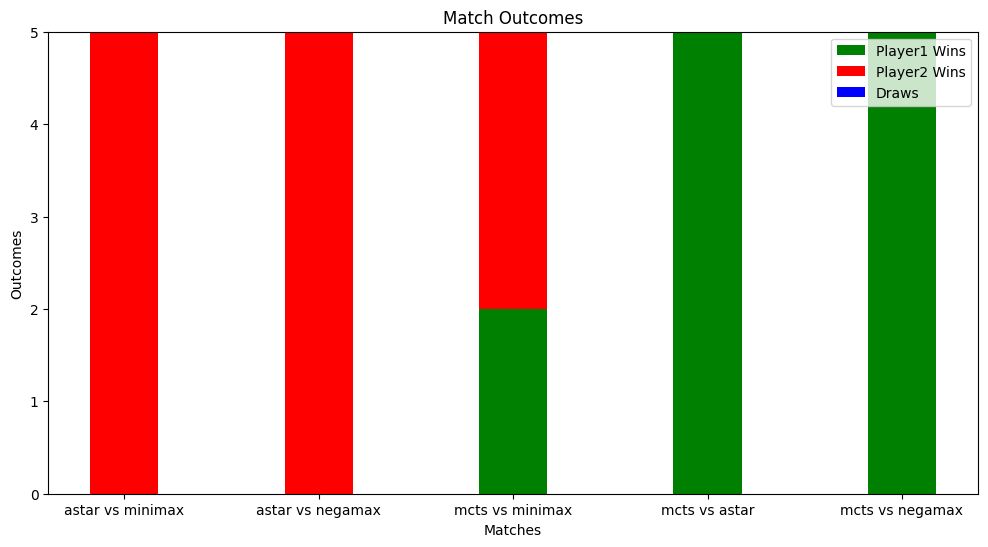

In [28]:
from matplotlib import pyplot as plt

sim1 = [x[0] for x in results]
sim2 = [x[1] for x in results]
draws = [x[2] for x in results]

# Defining labels for the bars
labels = ['astar vs minimax', 'astar vs negamax', 'mcts vs minimax', 'mcts vs astar', 'mcts vs negamax']

# Defining the positions for the bars
x = range(len(results))

plt.figure(figsize=(12, 6))  # Width: 10 inches, Height: 6 inches

bar_width = 0.35

# Plotting
plt.bar(x, sim1, color='g',width=bar_width, label='Player1 Wins')
plt.bar(x, sim2, color='r',width=bar_width, bottom=sim1, label='Player2 Wins')
plt.bar(x, draws, color='b',width=bar_width, bottom=[sim1[i] + sim2[i] for i in range(len(results))], label='Draws')

# Adding labels and title 
plt.xlabel('Matches')
plt.ylabel('Outcomes')
plt.title('Match Outcomes')
plt.xticks(x, labels)
plt.legend()

# Showing the plot
plt.show()